<a href="https://colab.research.google.com/github/Joshuahuang55/Machine-Learning-Green-trademark/blob/main/%E7%B6%A0%E8%89%B2%E5%95%86%E6%A8%99%E6%AC%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

## Goal


利用商標權的文字描述資料搭配人工判讀"綠色"的方法來訓練機器辨別綠色商標權

# Data Description and Pre-processing

## Data Source

資料來自美國智慧財產局USPTO裡面商標的statement以及case_file文件
連結:https://bulkdata.uspto.gov/data/trademark/casefile/economics/2020/

## Exploratory Data Analysis and Feature Engineering

### Package

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import nltk
import sklearn
nltk.download("popular")
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer
    )
# Load libraries

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm

import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.offline as py
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import nltk
from wordcloud import WordCloud

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

### Download Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_excel('/content/drive/My Drive/統計學習期末/green_trademark_label.xlsx')
df=df[["Green_TM_Label","statement_text"]]
df=df.dropna()
df=df.rename(columns={'Green_TM_Label': 'label'}) 
df["category"]=df['label']
map_dict = {1: "Green", 0:"non_Green"}
df['category'].replace(map_dict, inplace=True)

df.head(10)

,label,statement_text,category
0,0.0,"Electrical and electronic circuits, components...",non_Green
1,0.0,"Electrical and electronic circuits, components...",non_Green
2,0.0,Electrical and electronic circuits for active ...,non_Green
3,0.0,"Electrical and electronic circuits, electrical...",non_Green
4,0.0,"Housewares, namely, bowls, cups, dishes, heat-...",non_Green
5,0.0,"Housewares, namely, bowls, cake servers, cooki...",non_Green
6,0.0,Administration of holiday and vacation club ac...,non_Green
7,0.0,"Maintenance, repair and updating of computer s...",non_Green
8,0.0,Brake pads for vehicles,non_Green
9,1.0,Refrigerator condensing units and sealed units...,Green


### Summary Statistic

透過Histogram觀察標註出來的綠色或是非綠色商標權的數量

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Trademark Category')]

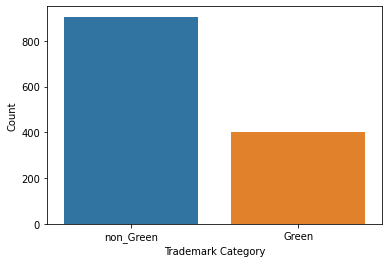

In [5]:
ax = sns.countplot(x=df['category'])
ax.set(xlabel='Trademark Category', ylabel='Count')

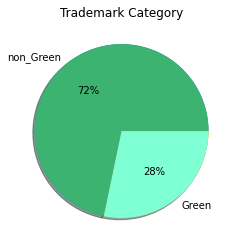

In [ ]:
data=[1078, 425]             
plt.pie(data)
labels=['non_Green', 'Green'] 
colors=['mediumseagreen','aquamarine']  
plt.pie(data, autopct='%.0f%%', labels=labels, colors=colors, shadow=True)
plt.title('Trademark Category')
plt.show()

In [ ]:
df[['category']].describe()

,category
count,1503
unique,2
top,non_Green
freq,1078


In [ ]:
df['category'].value_counts()

non_Green    1078
Green         425
Name: category, dtype: int64

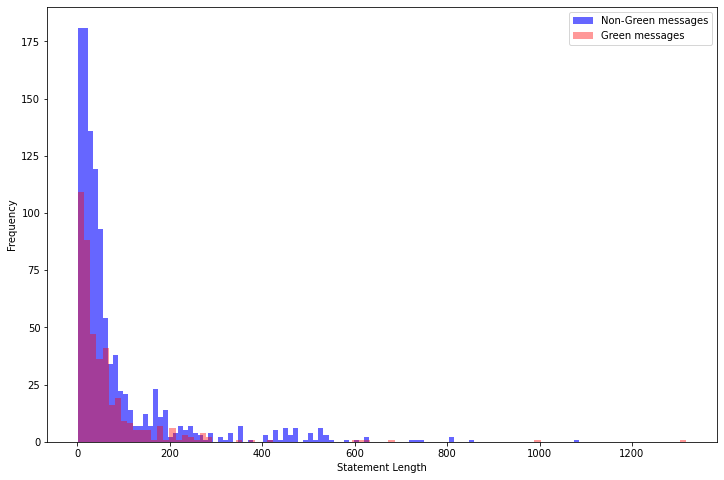

In [ ]:
df['word_length'] = df['statement_text'].apply(lambda x:len(x.split()))
plt.figure(figsize=(12, 8))

df[df.label==0].word_length.plot(bins=100, kind='hist', color='blue', 
                                       label='Non-Green messages', alpha=0.6)
df[df.label==1].word_length.plot(bins=100,kind='hist', color='red', 
                                       label='Green messages', alpha=0.4)
plt.legend()
plt.xlabel("Statement Length")
plt.show()

使用文字雲呈現資料

## 觀察Green和non-green常出現的字

     |████████████████████████████████| 115 kB 5.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



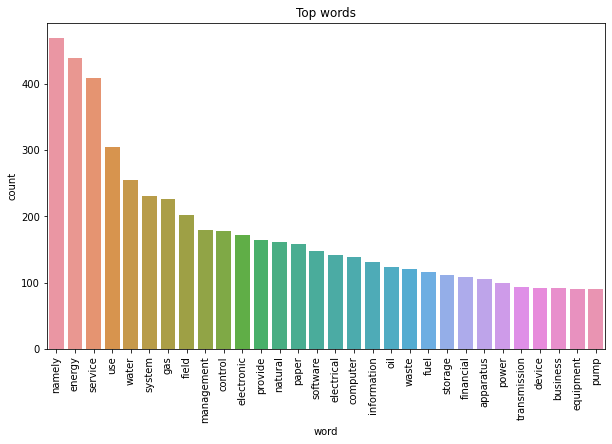

In [ ]:
!pip install text-hammer
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
  
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

cleaned_df = text_preprocessing(df[df.label==1], "statement_text")

import nltk



### Calculating the word frequency by using nltk
words_list = []
for sentence in cleaned_df.statement_text:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)
# freq_dist.keys()

temp = pd.DataFrame(freq_dist.most_common(30),  columns=['word', 'count'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=temp, ax=ax)
plt.title("Top words")
plt.xticks(rotation='vertical');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



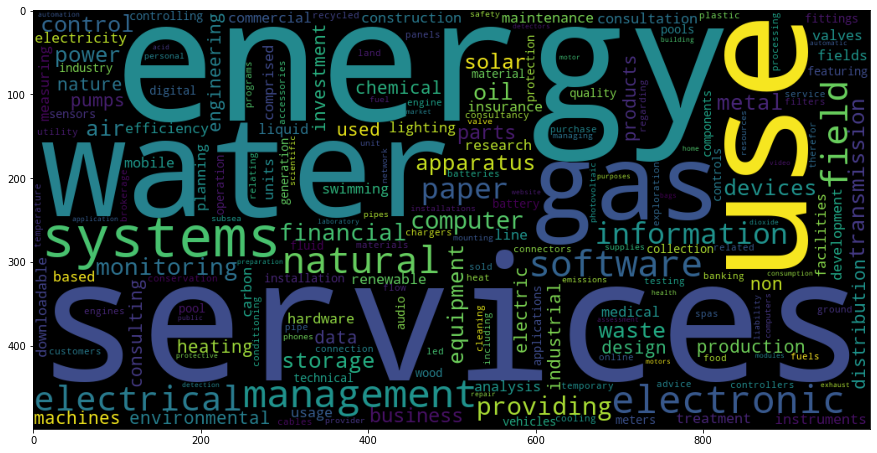

In [6]:
import collections
from sklearn.feature_extraction.text import CountVectorizer

g_subset = df[df['category']=='Green']
ng_subset = df[df['category']=='non_Green']
vectorizer_rmsw = CountVectorizer(stop_words="english")

## for green subset
text = []
for i in g_subset['statement_text']:
  text.append(i)

text_str = ''.join(text)
text_1=text_str.replace(',',' ')
text_1=text_1.replace(';',' ')
text_list = text_1.split() 

stop_word = vectorizer_rmsw.fit_transform(text_list)
stop_word = stop_word.toarray()
stop_word = pd.DataFrame(data=stop_word,columns = vectorizer_rmsw.get_feature_names())

word_could_dict = dict(stop_word.sum(axis = 0, skipna = True))
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)


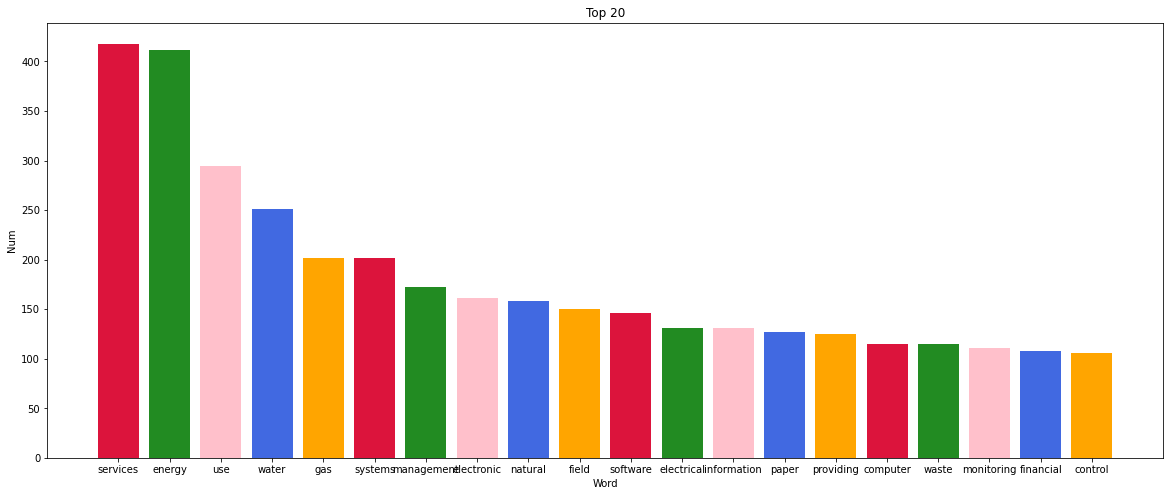

In [ ]:
# top 20 word list
word_could_dict = dict(sorted(word_could_dict.items(), key=lambda item: item[1], reverse = True))
name = list(word_could_dict.keys())[0:20] 
num = list(word_could_dict.values())[0:20] 
x = np.arange(len(name))
plt.figure(figsize=(20,8))
plt.bar(x, num, color=['crimson','forestgreen','pink','royalblue','orange'])
plt.xticks(x, name)
plt.xlabel('Word')
plt.ylabel('Num')
plt.title('Top 20')
plt.show()

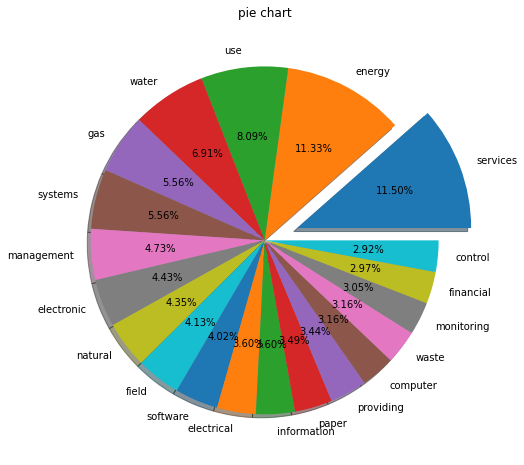

In [ ]:
plt.figure(figsize=(12,8))
explode = [0] * len(num)
explode[0] = 0.2
plt.pie(num, labels=name, autopct='%1.2f%%', explode=explode, shadow=True)
plt.title('pie chart')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



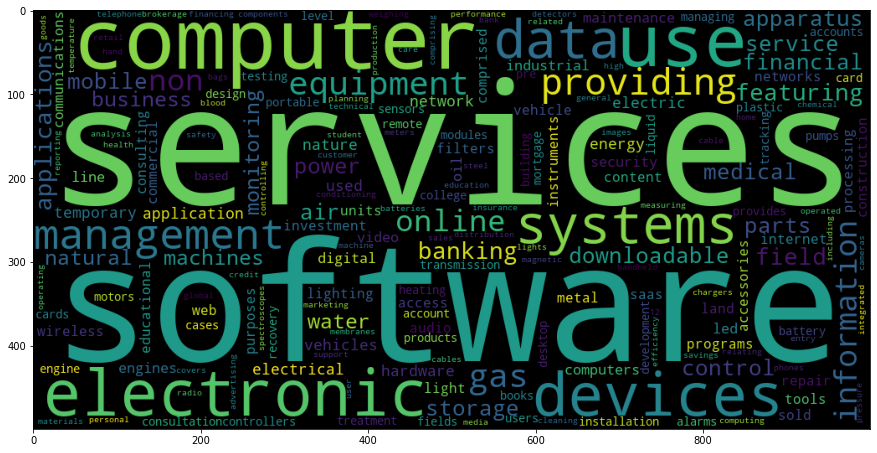

In [ ]:
## for non_green subset
text = []
for i in ng_subset['statement_text']:
  text.append(i)

text_str = ''.join(text)
text_1=text_str.replace(',',' ')
text_1=text_1.replace(';',' ')
text_list = text_1.split() 

stop_word = vectorizer_rmsw.fit_transform(text_list)
stop_word = stop_word.toarray()
stop_word = pd.DataFrame(data=stop_word,columns = vectorizer_rmsw.get_feature_names())

word_could_dict = dict(stop_word.sum(axis = 0, skipna = True))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)



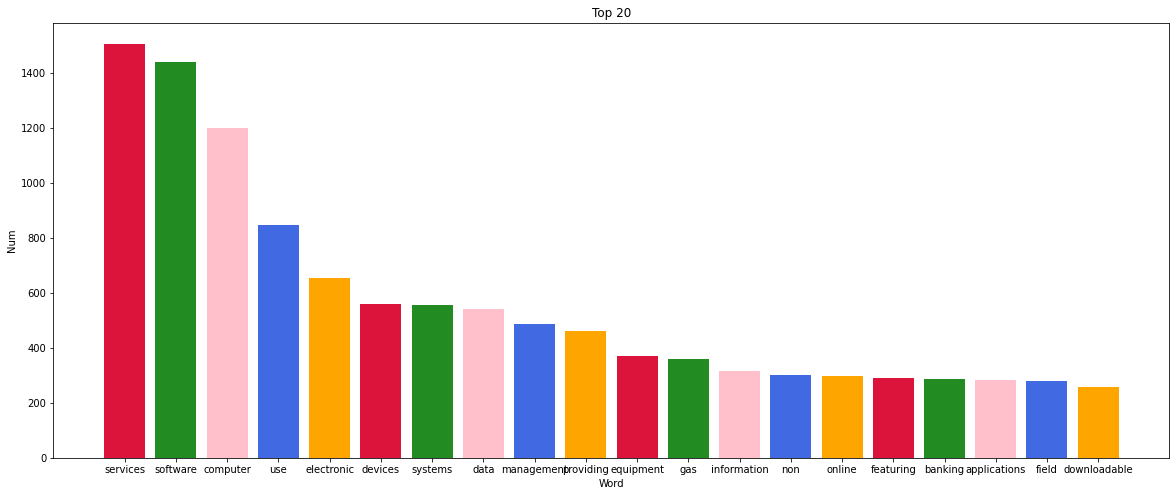

In [ ]:
# top 20 word list
word_could_dict = dict(sorted(word_could_dict.items(), key=lambda item: item[1], reverse = True))
name = list(word_could_dict.keys())[0:20] 
num = list(word_could_dict.values())[0:20] 
x = np.arange(len(name))
plt.figure(figsize=(20,8))
plt.bar(x, num, color=['crimson','forestgreen','pink','royalblue','orange'])
plt.xticks(x, name)
plt.xlabel('Word')
plt.ylabel('Num')
plt.title('Top 20')
plt.show()

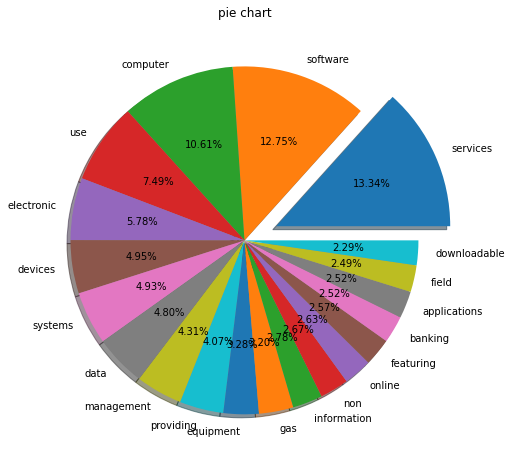

In [ ]:
plt.figure(figsize=(12,8))
explode = [0] * len(num)
explode[0] = 0.2
plt.pie(num, labels=name, autopct='%1.2f%%', explode =explode, shadow=True)
plt.title('pie chart')
plt.show()

使用長條圖去觀察敘述句子的長度

In [ ]:
df['length'] = df['statement_text'].apply(len)
df.head()

,label,statement_text,category,word_length,length
0,0.0,"Electrical and electronic circuits, components...",non_Green,59,496
1,0.0,"Electrical and electronic circuits, components...",non_Green,59,496
2,0.0,Electrical and electronic circuits for active ...,non_Green,70,588
3,0.0,"Electrical and electronic circuits, electrical...",non_Green,61,535
4,0.0,"Housewares, namely, bowls, cups, dishes, heat-...",non_Green,53,385


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



[Text(0, 0.5, 'Count'), Text(0.5, 0, 'length')]

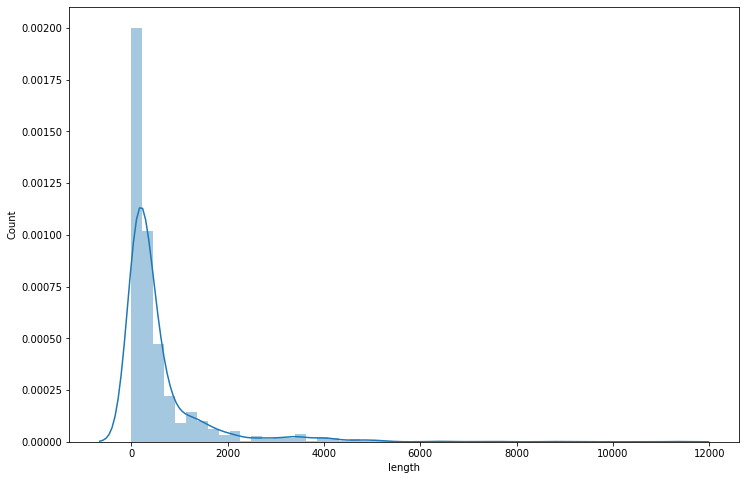

In [ ]:
plt.figure(figsize=(12,8))
length = sns.distplot(x=df['length'])
length.set(xlabel='length', ylabel='Count')

透過長條圖可以觀察到大部分的敘述長度位於0-500之間，儘管還是有一些特別長的敘述。

## Feature Engineering

清理文字資料

In [7]:
def preprocess(text):
    # Remove stopwords
    stopwords_list = stopwords.words('english')
    words = [i for i in text.split() if i.lower() not in stopwords_list]
    text_1 = ' '.join(words)
    # Remove puctuation and replace with a space.
    punc_string = string.punctuation
    text_2 = text_1.translate(str.maketrans(punc_string, len(punc_string)*' '))
    words_1 = text_2.split()
    # Perform word stemming 
    stemmer = SnowballStemmer('english')
    words_2 = [stemmer.stem(word) for word in words_1]
    text_3 = ' '.join(words_2)
    return text_3

In [8]:
#處理文字
nltk.download('stopwords')
df["statement_text"] = df["statement_text"].apply(preprocess)
df["statement_text"] = df["statement_text"].apply(preprocess)
df_train, df_test = train_test_split(df, stratify=df["label"],test_size=0.2,random_state=22)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:

def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

def generate_key_list(df_train , size_table=200,ignore=3):
    dict_green_raw = dict()
    dict_non_green_raw = dict()
    dict_IDF_green = dict()# ignore all other than letters.
    dict_IDF_non_green = dict()# ignore all other than letters.
    
    finds_green = df_train[df_train['label'] == 1.0]["statement_text"].apply(len)
    finds_non_green = df_train[df_train['label'] == 0.0]["statement_text"].apply(len)
    green_word_num = sum(pd.DataFrame(finds_green)["statement_text"])
    non_green_word_num = sum(pd.DataFrame(finds_non_green)["statement_text"])

    for i in range(df_train.shape[0]):
        finds = re.findall('[A-Za-z]+', df_train.iloc[i]["statement_text"])
        if df_train.iloc[i].label == 1.0:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower() #英文轉成小寫
                try:
                    dict_green_raw[find] = dict_green_raw[find] + 1
                except: 
                    dict_green_raw[find] = dict_green_raw.get(find,1)
                    dict_non_green_raw[find] =  dict_non_green_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower()
                try:
                    dict_non_green_raw[find] = dict_non_green_raw[find] + 1
                except: 
                    dict_non_green_raw[find] = dict_non_green_raw.get(find,1)
                    dict_green_raw[find] = dict_green_raw.get(find,0)
  

        if df_train.iloc[i].label == 1.0:
          word_set_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_green):
                try:
                    dict_IDF_green[find] = dict_IDF_green[find] + 1
                except: 
                    dict_IDF_green[find] = dict_IDF_green.get(find,1)
                    dict_IDF_non_green[find] =  dict_IDF_non_green.get(find,0)

            word_set_green.add(find)
        else:
          word_set_non_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_non_green):
                try:
                    dict_IDF_non_green[find] = dict_IDF_non_green[find] + 1
                except: 
                    dict_IDF_non_green[find] = dict_IDF_non_green.get(find,1)
                    dict_IDF_green[find] =  dict_IDF_green.get(find,0)
     
            word_set_non_green.add(find)

    word_df = pd.DataFrame(list(zip(dict_non_green_raw.keys(),dict_non_green_raw.values(),dict_green_raw.values(),dict_IDF_green.values(),dict_IDF_non_green.values())))
    word_df.columns = ['keyword','non_green','green','IDF_green','IDF_non_green']
    word_df['non_green'] = word_df['non_green'].astype('float')/df_train[df_train['category']=="non_Green"].shape[0]
    word_df['green'] = word_df['green'].astype('float')/df_train[df_train['category']=="Green"].shape[0]
    word_df['IDF_green'] = np.log10(green_word_num/(1+word_df['IDF_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['IDF_non_green'] = np.log10(non_green_word_num/(1+word_df['IDF_non_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['no_green_IDF'] = word_df['non_green']*word_df['IDF_non_green']  
    word_df['green_IDF'] = word_df['green']*word_df['IDF_green']
    word_df['diff']=word_df['green_IDF']-word_df['no_green_IDF']
    selected_green_key = word_df.sort_values('diff',ascending=False)  
    keyword_dict = dict()
    
    i = 0
    for word in selected_green_key.head(size_table).keyword:
        keyword_dict.update({word.strip():i})
        i+=1
    return keyword_dict   

def generate_key_ngram(df_train,size_table=200,ignore=3,ngram=2):
    dict_green_raw = dict()
    dict_non_green_raw = dict()
    dict_IDF = dict()# ignore all other than letters.

    for i in range(df_train.shape[0]):
        text=df_train.iloc[i]["statement_text"]
        finds =  get_ngrams(text, ngram )

        if df_train.iloc[i].label == 1.0:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower() #英文轉成小寫
                try:
                    dict_green_raw[find] = dict_green_raw[find] + 1
                except: 
                    dict_green_raw[find] = dict_green_raw.get(find,1)
                    dict_non_green_raw[find] =  dict_non_green_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower()
                try:
                    dict_non_green_raw[find] = dict_non_green_raw[find] + 1
                except: 
                    dict_non_green_raw[find] = dict_non_green_raw.get(find,1)
                    dict_green_raw[find] = dict_green_raw.get(find,0)
  
        word_set = set()
        for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set):
                try:
                    dict_IDF[find] = dict_IDF[find] + 1
                except: 
                    dict_IDF[find] = dict_IDF.get(find,1)
            word_set.add(find)
     
    
    word_df = pd.DataFrame(list(zip(dict_non_green_raw.keys(),dict_non_green_raw.values(),dict_green_raw.values(),dict_IDF.values())))
    word_df.columns = ['keyword','non_green','green','IDF']
    word_df['non_green'] = word_df['non_green'].astype('float')/df_train[df_train['label']=='non_green'].shape[0]
    word_df['green'] = word_df['green'].astype('float')/df_train[df_train['label']=='green'].shape[0]
    word_df['IDF'] = np.log10(word_df.shape[0]/word_df['IDF'].astype('float'))
    word_df['no_green_IDF'] = word_df['non_green']*word_df['IDF']
    word_df['green_IDF'] = word_df['green']*word_df['IDF']
    word_df['diff']=word_df['green_IDF']-word_df['no_green_IDF']
    selected_green_key = word_df.sort_values('diff',ascending=False)  
    keyword_dict = dict()
    
    i = 0
    for word in selected_green_key.head(size_table).keyword:
        keyword_dict.update({word.strip():i})
        i+=1
    return keyword_dict   

def convert_Content(content, keyword_dict):
	m = len(keyword_dict)
	res = np.int_(np.zeros(m))
	finds = re.findall('[A-Za-z]+', content)
	for find in finds:
		find=find.lower()
		try:
			i = keyword_dict[find]
			res[i]=1
		except:
			continue
	return res

def raw2feature(df_train,df_test,keyword_dict):
    n_train = df_train.shape[0]
    n_test = df_test.shape[0]
    m = len(keyword_dict)
    X_train = np.zeros((n_train,m));
    X_test = np.zeros((n_test,m));
    Y_train = np.int_(df_train.label==1)
    Y_test = np.int_(df_test.label==1)
    for i in range(n_train):
        X_train[i,:] = convert_Content(df_train.iloc[i]["statement_text"], keyword_dict)
    for i in range(n_test):
        X_test[i,:] = convert_Content(df_test.iloc[i]["statement_text"], keyword_dict)
        
    return [X_train,Y_train],[X_test,Y_test]



     

檢視關鍵的重要詞 - Unigram

In [10]:
# build a tabu list based on the training data
size_table = 400                # how many features are used to classify spam
word_len_ignored = 3           # ignore those words shorter than this variable
keyword_dict=generate_key_list(df_train ,size_table, word_len_ignored)

In [11]:
sorted(keyword_dict.items(), key=lambda x:x[1])[0:50]

[('energi', 0),
 ('water', 1),
 ('paper', 2),
 ('wast', 3),
 ('electr', 4),
 ('gas', 5),
 ('product', 6),
 ('pool', 7),
 ('invest', 8),
 ('natur', 9),
 ('environ', 10),
 ('renew', 11),
 ('valv', 12),
 ('solar', 13),
 ('pump', 14),
 ('financ', 15),
 ('usag', 16),
 ('metal', 17),
 ('distribut', 18),
 ('transmiss', 19),
 ('insur', 20),
 ('emiss', 21),
 ('util', 22),
 ('liabil', 23),
 ('storag', 24),
 ('spas', 25),
 ('chemic', 26),
 ('heat', 27),
 ('consult', 28),
 ('wood', 29),
 ('oil', 30),
 ('field', 31),
 ('reduct', 32),
 ('fuel', 33),
 ('swim', 34),
 ('recycl', 35),
 ('carbon', 36),
 ('purcha', 37),
 ('effici', 38),
 ('qualiti', 39),
 ('meter', 40),
 ('conserv', 41),
 ('fluid', 42),
 ('contamin', 43),
 ('facil', 44),
 ('rail', 45),
 ('research', 46),
 ('reagent', 47),
 ('sampl', 48),
 ('signag', 49)]

In [ ]:
min(keyword_dict, key=keyword_dict.get)

'energi'

# Modeling and Inference (Green TF-IDF Method)

將前面篩選出來的特徵關鍵字套在training data跟testing data進而將文字資料轉成向量

In [12]:
Train_gram,Test_gram=raw2feature(df_train,df_test,keyword_dict)
X_train_gram = Train_gram[0]
X_train_gram = pd.DataFrame(X_train_gram)
X_train_gram.columns = keyword_dict.keys()

Y_train = Train_gram[1] 

X_test_gram = Test_gram[0]
X_test_gram = pd.DataFrame(X_test_gram)
X_test_gram.columns = keyword_dict.keys()

Y_test = Test_gram[1]


In [13]:
Y_train_df = pd.DataFrame(Y_train)
Y_train_df.columns=['label']

In [14]:
Model_Matrix = pd.merge(X_train_gram, Y_train_df, left_index=True, right_index=True)
Model_Matrix

,energi,water,paper,wast,electr,gas,product,pool,invest,natur,environ,renew,valv,solar,pump,financ,usag,metal,distribut,transmiss,insur,emiss,util,liabil,storag,spas,chemic,heat,consult,wood,oil,field,reduct,fuel,swim,recycl,carbon,purcha,effici,qualiti,...,rigid,inspect,amplifi,microscop,associ,extrud,oxid,annuiti,cone,loudspeak,biochem,forgo,substrat,understand,profess,bill,stuf,grow,price,rubber,inject,side,free,physic,phosphat,conductor,constitu,rate,remov,electromagnet,technic,sprinkler,heavi,websit,interv,litig,blunt,asbesto,titrat,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1042,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1044,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
#X_train = pd.merge(X_train_gram, X_train_bigram, left_index=True, right_index=True)
#X_test = pd.merge(X_test_gram, X_test_bigram, left_index=True, right_index=True)
X_train = X_train_gram
X_test = X_test_gram

## 先把Random Search 跟 Grid Search 的 function 寫好

In [16]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred
    

In [17]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

## Logistic Regression

In [ ]:
# model
model = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

LR_RandSearch = RandomSearch(X_train,Y_train,model,hyperparameters)

# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
#Prediction_LR = LR_RandSearch.BestModelPridict(X_test)

In [ ]:
model_logis = LogisticRegression(penalty='l2', C= 1.882563230649684)
model_logis.fit(X_train, Y_train)

LogisticRegression(C=1.882563230649684)

In [ ]:
Prediction_LR = model_logis.predict(X_test)
print('Accuracy : {:.5f}'.format(model_logis.score(X_test, Y_test)))

Accuracy : 0.79008


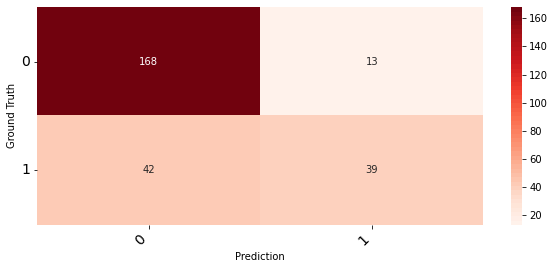

Accuray: 79.008%
ROC-AUC: 0.70483
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       181
           1       0.75      0.48      0.59        81

    accuracy                           0.79       262
   macro avg       0.78      0.70      0.72       262
weighted avg       0.78      0.79      0.77       262



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_LR)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_LR), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_LR), 5)}""")
print(classification_report(Y_test, Prediction_LR))

result = classification_report(Y_test, Prediction_LR)

In [ ]:
Model_Matrix.columns[indices[:17]]

Index(['servo', 'auxiliari', 'washabl', 'conscious', 'flash', 'tear', 'solar',
       'baghous', 'landfil', 'gaseous', 'wast', 'garbag', 'liquid', 'conserv',
       'pellet', 'robot', 'theori'],
      dtype='object')

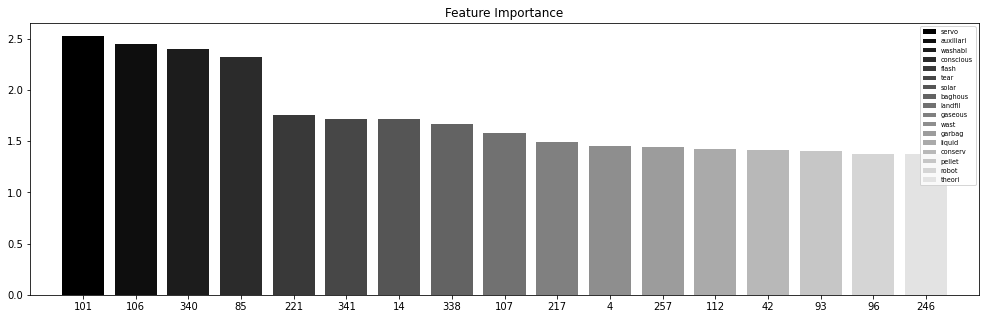

In [ ]:
features = {
    "f101": u"servo",
    "f106": u"auxiliari",
    "f340": u"washabl",
    "f85": u"conscious",
    "f221": u"flash",
    "f341": u"tear",
    "f14": u"solar",
    "f338": u"baghous",
    "f107": u"landfil",
    "f217": u"gaseous",
    "f4": u"wast",
    "f257": u"garbag",
    "f112": u"liquid",
    "f42": u"conserv",
    "f93": u"pellet",
    "f96": u"robot",
    "f93": u"pellet",
    "f246": u"theori",
    "f217": u"gaseous"
}

# Plot the feature importancies 
coefs = np.abs(model_logis.coef_[0])
indices = np.argsort(coefs)[::-1]
num_to_plot = 17
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(17, 5))
plt.title(u"Feature Importance")
bars = plt.bar(range(17), coefs[indices[:17]],
       color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]), 
        align="center")


ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices],fontsize = 6.5);

## LDA

In [ ]:
from numpy import arange
# define model
model_LDA = LinearDiscriminantAnalysis()



solver=['svd', 'lsqr','eigen']
n_components=arange(1,10,1)
store_covariance=[True, False]
tol= [0.0001, 0.001,0.01, 0.1]

# Create hyperparameter options

hyperparameters = dict( solver=solver,n_components=n_components,store_covariance=store_covariance,tol=tol  )

LDA_RandSearch = GridSearch(X_train,Y_train,model_LDA,hyperparameters)

Prediction_LDA = LDA_RandSearch.BestModelPridict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


2000 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py", line 603, in fit
    covariance_estimator=self.covariance_estimator,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py", line 440, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/usr/lo

Best: 0.756190 using {'n_components': 1, 'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}


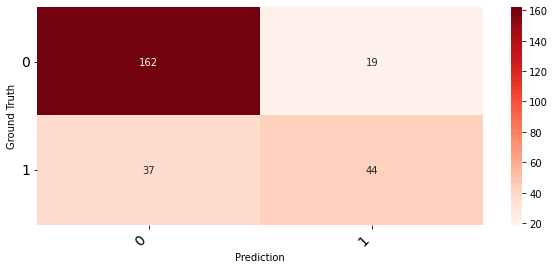

Accuray: 78.62599999999999%
ROC-AUC: 0.71912
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       181
           1       0.70      0.54      0.61        81

    accuracy                           0.79       262
   macro avg       0.76      0.72      0.73       262
weighted avg       0.78      0.79      0.78       262



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_LDA)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_LDA), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_LDA), 5)}""")
print(classification_report(Y_test, Prediction_LDA))



## KNN

In [ ]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

KNN_GridSearch = GridSearch(X_train,Y_train,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_test)

Prediction_KNN_train = KNN_GridSearch.BestModelPridict(X_train)

Best: 0.781136 using {'n_neighbors': 1}
Best: 0.781136 using {'n_neighbors': 1}


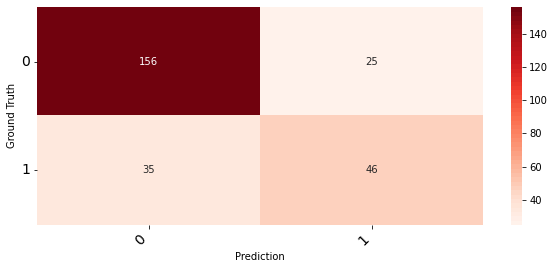

Accuray: 77.09899999999999%
ROC-AUC: 0.71489
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       181
           1       0.65      0.57      0.61        81

    accuracy                           0.77       262
   macro avg       0.73      0.71      0.72       262
weighted avg       0.76      0.77      0.77       262



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_KNN)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_KNN), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_KNN), 5)}""")
print(classification_report(Y_test, Prediction_KNN))



## DecisionTreeClassifier

In [ ]:
model_Cart = DecisionTreeClassifier()
# parameters
max_leaf_nodes = list(range(2, 100))
min_samples_split = list(range(2, 5)) 
max_depth = None

params_Cart = dict(max_leaf_nodes=max_leaf_nodes,
          min_samples_split=min_samples_split)
Cart_Gridsearch = GridSearch(X_train,Y_train,model_Cart,params_Cart)
Prediction_Cart = Cart_Gridsearch.BestModelPridict(X_test)

Best: 0.797299 using {'max_leaf_nodes': 96, 'min_samples_split': 2}


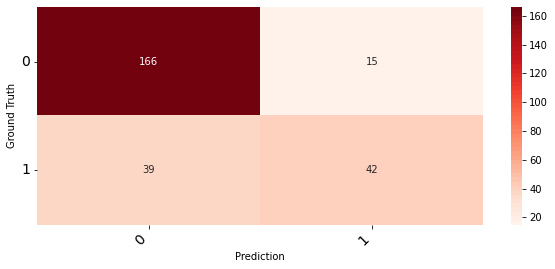

Accuray: 79.389%
ROC-AUC: 0.71782
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       181
           1       0.74      0.52      0.61        81

    accuracy                           0.79       262
   macro avg       0.77      0.72      0.73       262
weighted avg       0.79      0.79      0.78       262



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_Cart)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_Cart), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_Cart), 5)}""")
print(classification_report(Y_test, Prediction_Cart))

## Naive Bayes

### Gausian

In [ ]:
model_NB = GaussianNB()
#var_smoothing=[1e-8]
nb_parameters = {'var_smoothing': [1e-15,1e-12,1e-10,1e-08]}

#nb_parameters=dict(var_smoothing=var_smoothing)
NB_GridSearch = GridSearch(X_train,Y_train,model_NB,nb_parameters)
Prediction_NB = NB_GridSearch.BestModelPridict(X_test)
Prediction_NB_train = NB_GridSearch.BestModelPridict(X_train)

Best: 0.748562 using {'var_smoothing': 1e-15}
Best: 0.748562 using {'var_smoothing': 1e-15}


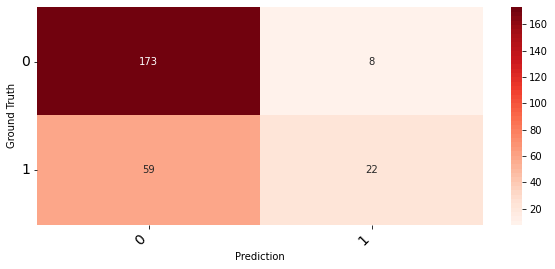

Accuray: 74.42699999999999%
ROC-AUC: 0.6137
              precision    recall  f1-score   support

           0       0.75      0.96      0.84       181
           1       0.73      0.27      0.40        81

    accuracy                           0.74       262
   macro avg       0.74      0.61      0.62       262
weighted avg       0.74      0.74      0.70       262



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_NB)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_NB), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_NB), 5)}""")
print(classification_report(Y_test, Prediction_NB))


### Multinomial

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model_NB = MultinomialNB()
#var_smoothing=[1e-8]
nb_parameters = {'alpha': [1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01]}

#nb_parameters=dict(var_smoothing=var_smoothing)
NB_GridSearch = GridSearch(X_train,Y_train,model_NB,nb_parameters)
Prediction_NB = NB_GridSearch.BestModelPridict(X_test)
Prediction_NB_train = NB_GridSearch.BestModelPridict(X_train)

Best: 0.748516 using {'alpha': 0.09}
Best: 0.748516 using {'alpha': 0.09}


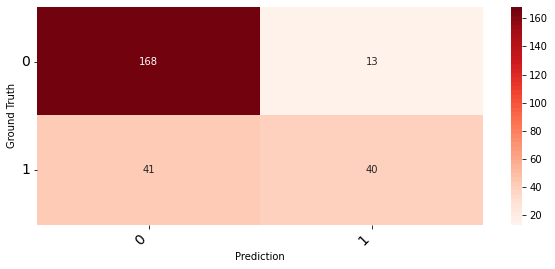

Accuray: 79.389%
ROC-AUC: 0.711
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       181
           1       0.75      0.49      0.60        81

    accuracy                           0.79       262
   macro avg       0.78      0.71      0.73       262
weighted avg       0.79      0.79      0.78       262



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_NB)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_NB), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_NB), 5)}""")
print(classification_report(Y_test, Prediction_NB))

## Support Vector Machine

In [ ]:
Y_train_svm = np.where(Y_train <= 0.5, -1, 1)
Y_test_svm = np.where(Y_test <= 0.5, -1, 1)
model_svm = svm.SVC()
kenel=['rbf', 'poly', 'sigmoid']
C=[0.1,1, 10, 100]
gamma=[1,0.1,0.01,0.001]
parameters=dict(kernel=kenel,C=C,gamma=gamma)
svm_GridSearch = GridSearch(X_train,Y_train_svm,model_svm,parameters)
Prediction_svm = svm_GridSearch.BestModelPridict(X_test)
Prediction_svm_train = svm_GridSearch.BestModelPridict(X_train)

Best: 0.821227 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best: 0.821227 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


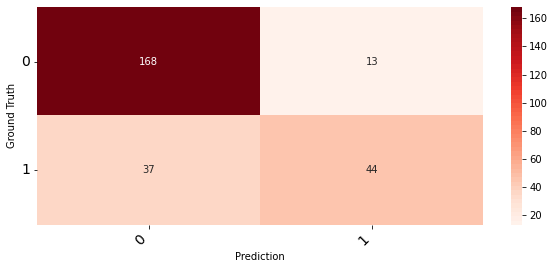

Accuray: 80.916%
ROC-AUC: 0.73569
              precision    recall  f1-score   support

          -1       0.82      0.93      0.87       181
           1       0.77      0.54      0.64        81

    accuracy                           0.81       262
   macro avg       0.80      0.74      0.75       262
weighted avg       0.80      0.81      0.80       262



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test_svm, Prediction_svm)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test_svm, Prediction_svm), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test_svm, Prediction_svm), 5)}""")
print(classification_report(Y_test_svm, Prediction_svm))

## AdaBoostClassifier

In [ ]:
learning_rate_value = [.01,.05,.07,.1,.5,.7,1]
n_estimators_value = [50,100,150,200,250,300]

In [ ]:
import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
model_Ad = AdaBoostClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

Ad_GridSearch = GridSearch(X_train, Y_train, model_Ad, param_grid)
Prediction_Ad = Ad_GridSearch.BestModelPridict(X_test)

Best: 0.787011 using {'learning_rate': 0.5, 'n_estimators': 200}


In [ ]:
model_Ad = AdaBoostClassifier(random_state=123, learning_rate=0.5, n_estimators=3000)
model_Ad = model_Ad.fit(X_train, Y_train)
# calculating score on training data
print("model_Ad training data score: ", model_Ad.score(X_train, Y_train))
# calculating score on testing data
print("model_Ad testing data score: ", model_Ad.score(X_test, Y_test))
#Predict the response for test dataset
pred_Ad = model_Ad.predict(X_test)

model_Ad training data score:  0.8935108153078203
model_Ad testing data score:  0.7906976744186046


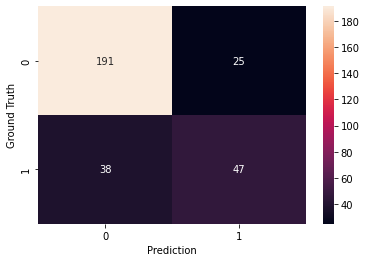

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true=Y_test, y_pred=pred_Ad)
cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

In [ ]:
# Plot AUC, ROC
print(f'AdaBoost Classifier Model Accuracy: {round(accuracy_score(Y_test, pred_Ad), 5) * 100}\n\ROC-AUC: {round(roc_auc_score(Y_test, pred_Ad), 5)}')
print(classification_report(Y_test, pred_Ad))

AdaBoost Classifier Model Accuracy: 79.07
\ROC-AUC: 0.7186
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       216
           1       0.65      0.55      0.60        85

    accuracy                           0.79       301
   macro avg       0.74      0.72      0.73       301
weighted avg       0.78      0.79      0.79       301



In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
# max error
print("Max error: ", max_error(Y_test, pred_Ad))

# mean absolute error
print("Mean absolute error: ", mean_absolute_error(Y_test, pred_Ad))

# mean root mean error
print("Root mean squared error: ", mean_squared_error(Y_test, pred_Ad, squared=False))

# r2 score
print("R2 score (Coefficient of determination): ", r2_score(Y_test, pred_Ad))

Max error:  1
Mean absolute error:  0.20930232558139536
Root mean squared error:  0.457495710997814
R2 score (Coefficient of determination):  -0.032843137254901844


In [ ]:
# Evaluate Model 
# Further evaluation with SVC base estimator 
# import Support Vector Classifier
from sklearn.svm import SVC

svc=SVC(probability=True, kernel='linear')

# create adaboost classifer object
model_Ad_svc = AdaBoostClassifier(n_estimators=300, base_estimator=svc, learning_rate=0.5, random_state=123)
# train adaboost classifer
model_Ad_svc = model_Ad_svc.fit(X_train, Y_train)

# predict the response for test dataset
pred_Ad2 = model_Ad_svc.predict(X_test)

# calculate and print model accuracy
print("Model Accuracy with SVC Base Estimator:",accuracy_score(Y_test, pred_Ad2))

Model Accuracy with SVC Base Estimator: 0.7142857142857143


## Gradient Boosting

In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300,400]
model_GB = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(X_train,Y_train,model_GB,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test)

Best: 0.815449 using {'learning_rate': 0.5, 'n_estimators': 150}


In [ ]:
model_GB = GradientBoostingClassifier(random_state=123, n_estimators=200, learning_rate=0.5)
model_GB = model_GB.fit(X_train, Y_train)
# calculating score on training data
print("model_GB training data score: ", model_GB.score(X_train, Y_train))
# calculating score on testing data
print("model_GB testing data score: ", model_GB.score(X_test, Y_test))

#Predict the response for test dataset
pred_GB = model_GB.predict(X_test)
# accuracy

accuracy = accuracy_score(Y_test, pred_GB)
print(accuracy)

model_GB training data score:  0.9416826003824091
model_GB testing data score:  0.8129770992366412
0.8129770992366412


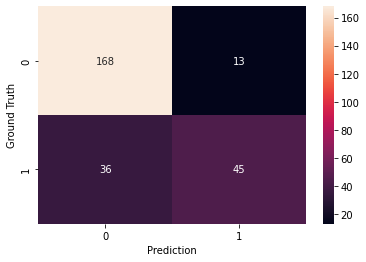

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true=Y_test, y_pred=pred_GB)
cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

In [ ]:
# Plot AUC, ROC
print(f'Accuray: {round(accuracy_score(Y_test, pred_GB), 5) * 100}%ROC-AUC: {round(roc_auc_score(Y_test, pred_GB), 5)}')
print(classification_report(Y_test, pred_GB))

Accuray: 81.298%ROC-AUC: 0.74187
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       181
           1       0.78      0.56      0.65        81

    accuracy                           0.81       262
   macro avg       0.80      0.74      0.76       262
weighted avg       0.81      0.81      0.80       262



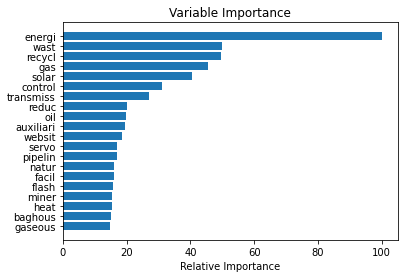

In [ ]:
feature_importance = model_GB.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[380:400].shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx][380:400], align='center')
plt.yticks(pos, X_train.columns[sorted_idx][380:400])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [1]:
# max error
print("Max error:", max_error(Y_test, pred_GB))

# mean absolute error
print("Mean absolute error:", mean_absolute_error(Y_test, pred_GB))

# mean root mean error
print("Root mean squared error:", mean_squared_error(Y_test, pred_GB, squared=False))

# r2 score
print("R2 score (Coefficient of determination):", r2_score(Y_test, pred_GB))

## Random Forest

In [19]:
import numpy as np 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [16,20,24]
# Minimum number of samples required to split a node
min_samples_split = [6,7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.metrics import accuracy_score
import random
random.seed(7)
model_RF = RandomForestClassifier()
RF_GridSearch = GridSearch(X_train,Y_train,model_RF,param_grid)
Prediction_RF = RF_GridSearch.BestModelPridict(X_test)

accuracy = accuracy_score(Y_test, Prediction_RF)
print(accuracy)

Best: 0.813544 using {'bootstrap': False, 'max_depth': 24, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 56}
0.8129770992366412


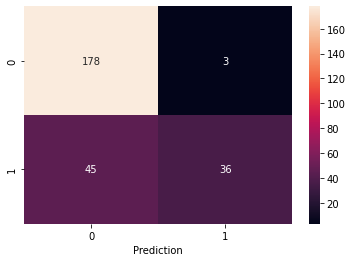

In [ ]:
# Plot confusion matrix 
cm = confusion_matrix(y_true=Y_test, y_pred=Prediction_RF)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
plt.xlabel('Prediction')
plt.show()

In [ ]:
# AUC, ROC
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_RF), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_RF), 5)}""")
print(classification_report(Y_test, Prediction_RF))

Accuray: 81.679%
ROC-AUC: 0.71393
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       181
           1       0.92      0.44      0.60        81

    accuracy                           0.82       262
   macro avg       0.86      0.71      0.74       262
weighted avg       0.84      0.82      0.79       262



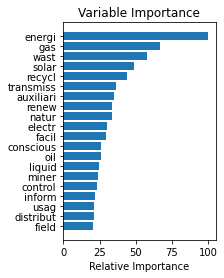

In [ ]:

random.seed(7)
rf = RandomForestClassifier(bootstrap = False, max_depth = 24, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 6, n_estimators = 56)
rf.fit(X_train, Y_train)

# #############################################################################
# Plot feature importance
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[380:400].shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx][380:400], align='center')
plt.yticks(pos, X_train.columns[sorted_idx][380:400])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
indices = np.argsort(feature_importance)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 20
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]
feature_indices

[1,
 6,
 4,
 14,
 36,
 20,
 106,
 12,
 10,
 5,
 45,
 85,
 31,
 112,
 71,
 111,
 170,
 17,
 19,
 32]

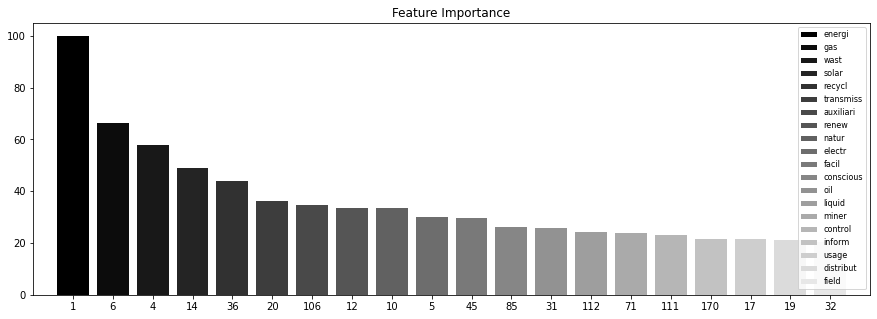

In [ ]:
features = {
    "f1": u"energi",
    "f6": u"gas",
    "f4": u"wast",
    "f14": u"solar",
    "f36": u"recycl",
    "f20": u"transmiss",
    "f106": u"auxiliari",
    "f12": u"renew",
    "f10": u"natur",
    "f5": u"electr",
    "f45": u"facil",
    "f85": u"conscious",
    "f31": u"oil",
    "f112": u"liquid",
    "f71": u"miner",
    "f111": u"control",
    "f170": u"inform",
    "f17": u"usage",
    "f19": u"distribut",
    "f32": u"field",
    "f142": u"reduc",
    "f199": u"pipelin",
    "f341": u"tear",
}

indices = np.argsort(feature_importance)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 20
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    feature_importance[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices],fontsize = 8);

## Extra Tree

In [20]:
model_ET = ExtraTreesClassifier()
ET_GridSearch = GridSearch(X_train,Y_train,model_ET,param_grid)
Prediction_ET = ET_GridSearch.BestModelPridict(X_test)

accuracy = accuracy_score(Y_test, Prediction_ET)
print(accuracy)

Best: 0.813599 using {'bootstrap': False, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 64}
0.8053435114503816


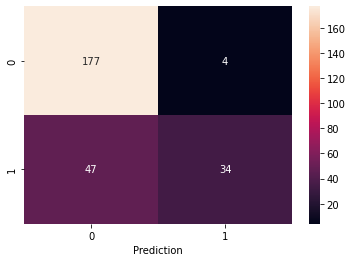

In [21]:
# Plot confusion matrix 
cm = confusion_matrix(y_true=Y_test, y_pred=Prediction_ET)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
plt.xlabel('Prediction')
plt.show()

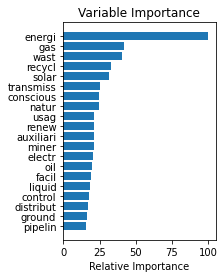

array([235, 155,  25, 303,  93, 308, 351,  23, 240, 239])

In [22]:
clf = ExtraTreesClassifier(bootstrap = False, max_depth = 24, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 6, n_estimators = 64)

clf.fit(X_train, Y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[380:400].shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx][380:400], align='center')
plt.yticks(pos, X_train.columns[sorted_idx][380:400])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
sorted_idx[0:10]

## 全流程

In [ ]:
result_dict = {} 
result_dict["Logistic"] = round(accuracy_score(Y_test, Prediction_LR), 5)
result_dict["LDA"] = round(accuracy_score(Y_test, Prediction_LDA), 5)
result_dict["Decision Tree"] = round(accuracy_score(Y_test, Prediction_Cart), 5)
result_dict["SVM"] = round(accuracy_score(Y_test_svm, Prediction_svm), 5)
result_dict["XGB"] = round(accuracy_score(Y_test, pred_GB), 5)
result_dict["RF"] = round(accuracy_score(Y_test, Prediction_RF), 5)

result_table = pd.DataFrame(result_dict.items())
result_table.rename(columns={0: 'Model',1: 'Testing Accuracy'}, inplace=True)

In [ ]:
result_table

,0,1
0,Logistic,0.79008
1,LDA,0.78626
2,Decision Tree,0.79389
3,SVM,0.80916
4,XGB,0.81298
5,RF,0.81298


## Add noise

In [ ]:
import random 
random.seed(7)
X_train_noise = X_train
X_test_noise = X_test

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise['energi']))]
X_train_noise["noise"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise['energi']))]
X_test_noise["noise"] = noise_test

In [ ]:
random.seed(318)
X_train_noise_2 = X_train_noise
X_test_noise_2 = X_test_noise

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise_2['energi']))]
X_train_noise["noise_2"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise_2['energi']))]
X_test_noise["noise_2"] = noise_test

In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300,400]
model_GB_noise = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(X_train_noise,Y_train,model_GB_noise,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test_noise)

Best: 0.804038 using {'learning_rate': 0.05, 'n_estimators': 400}


In [ ]:
model_GB = GradientBoostingClassifier(random_state=123, n_estimators=150, learning_rate=0.5)
model_GB = model_GB.fit(X_train, Y_train)

In [ ]:
feature_importance = model_GB.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

print(list(X_train_noise_2.columns[sorted_idx]).index("noise"))
print(list(X_train_noise_2.columns[sorted_idx]).index("noise_2"))


373
387


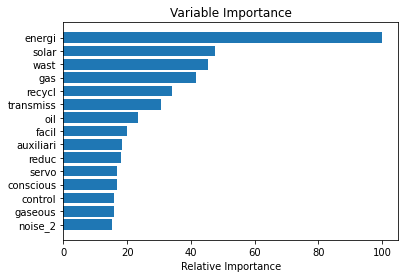

In [ ]:
pos = np.arange(sorted_idx[387:402] .shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx][387:402], align='center')
plt.yticks(pos, X_train.columns[sorted_idx][387:402])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

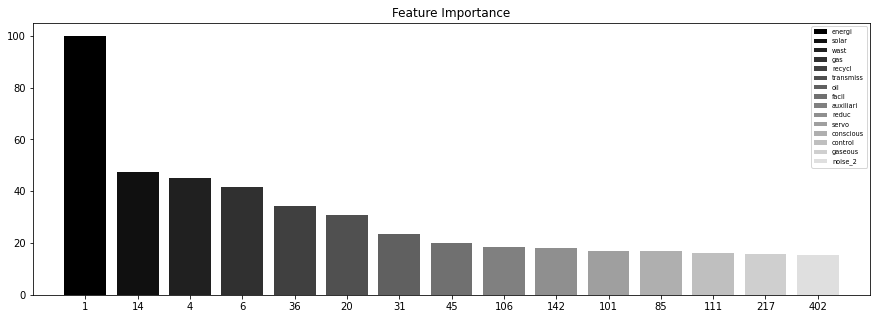

In [ ]:
features = {
    "f1": u"energi",
    "f14": u"solar",
    "f4": u"wast",
    "f6": u"gas",
    "f36": u"recycl",
    "f20": u"recycl",
    "f31": u"oil",
    "f45": u"facil",
    "f106": u"auxiliari",
    "f142": u"reduc",
    "f20": u"transmiss",
    "f111": u"control",
    "f221": u"flash",
    "f85": u"conscious",
    "f101": u"servo",
    "f2": u"water",
    "f93": u"pellet",
    "f71": u"miner",
    "f217": u"gaseous",
    "f45": u"facil",
    "f64": u"paramet",
    "f17": u"usag",
    "f104": u"liquid",
    "f340": u"washabi",
    "f341": u"tear",
    "f338": u"baghour",
    "f81": u"newsprint",
    "f402": u"noise_2",
}

indices = np.argsort(feature_importance)[::-1]
# Plot the feature importancies 
num_to_plot = 15
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    feature_importance[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices],fontsize = 6.5);

In [ ]:
# Always good to set a seed for reproducibility
SEED = 7
np.random.seed(SEED)

In [ ]:
def get_models():
    """Generate a library of base learners."""
    param = {'C': 3.730229437354635, 'penalty': 'l2'}
    model1 = LogisticRegression(**param)

    param = {'n_components': 1, 'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}
    model2 = LinearDiscriminantAnalysis(**param)

    param = {'n_neighbors': 1}
    model3 = KNeighborsClassifier(**param)

    param = {'C': 1.7, 'kernel': 'linear', 'probability':True}
    model4 = SVC(**param)

    param = {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3}
    model5 = DecisionTreeClassifier(**param)

    param = {'learning_rate': 0.05, 'n_estimators': 150}
    model6 = AdaBoostClassifier(**param)

    param = {'learning_rate': 0.05, 'n_estimators': 100}
    model7 = GradientBoostingClassifier(**param)

    model8 = GaussianNB()

    param = {'bootstrap': False, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
    model9 = RandomForestClassifier(**param)
    
    param = {'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
    model10 = ExtraTreesClassifier(**param)

    models = {'LR':model1, 'LDA':model2 , 'KNN':model3, 'SVC':model4,
              'DT':model5, 'ADa':model6, 'GB':model7,
              'NB':model8, 'RF':model9,  'ET':model10
              }

    return models



In [ ]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED,shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [ ]:
models = get_models()

In [23]:
BasedLine2(X_train,Y_train,models)

In [ ]:
num_folds = 10
scoring = 'accuracy'

results = []
names = []
for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=None,shuffle=True)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [ ]:
names,results = BasedLine2(X_train, Y_train,models)
PlotBoxR().PlotResult(names,results)

In [ ]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    return basedModels

In [ ]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED,shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [ ]:
class PlotBoxR(object):
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []
        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))
        py.iplot(data)


In [ ]:
models = GetBasedModel()
names,results = BasedLine2(X_train, Y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.766786 (0.032703)
LDA: 0.764863 (0.031643)
KNN: 0.745687 (0.032069)
CART: 0.777335 (0.039638)
NB: 0.753407 (0.026079)
SVM: 0.805980 (0.042382)
AB: 0.750577 (0.042937)
GBM: 0.782125 (0.032640)
RF: 0.789762 (0.045763)
ET: 0.799322 (0.046762)


In [ ]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [ ]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore

In [ ]:
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=SEED)

clf.fit(X_train, Y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


In [ ]:
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=SEED)

clf.fit(X_train, Y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


In [ ]:
rf = RandomForestClassifier()

rf.fit(X_train, Y_train)

# #############################################################################
# Plot feature importance
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Modeling and Inference (Green TF-IDF with PCA)

## 先把Random Search 跟 Grid Search 的 function 寫好

In [ ]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

## PCA 特徵降維

產生特徵(詞)的function

In [ ]:
def generate_key_list(df_train , size_table=200,ignore=3):
    dict_green_raw = dict()
    dict_non_green_raw = dict()
    dict_IDF_green = dict()# ignore all other than letters.
    dict_IDF_non_green = dict()# ignore all other than letters.
    
    finds_green = df_train[df_train['label'] == 1.0]["statement_text"].apply(len)
    finds_non_green = df_train[df_train['label'] == 0.0]["statement_text"].apply(len)
    green_word_num = sum(pd.DataFrame(finds_green)["statement_text"])
    non_green_word_num = sum(pd.DataFrame(finds_non_green)["statement_text"])

    for i in range(df_train.shape[0]):
        finds = re.findall('[A-Za-z]+', df_train.iloc[i]["statement_text"])
        if df_train.iloc[i].label == 1.0:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower() #英文轉成小寫
                try:
                    dict_green_raw[find] = dict_green_raw[find] + 1
                except: 
                    dict_green_raw[find] = dict_green_raw.get(find,1)
                    dict_non_green_raw[find] =  dict_non_green_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower()
                try:
                    dict_non_green_raw[find] = dict_non_green_raw[find] + 1
                except: 
                    dict_non_green_raw[find] = dict_non_green_raw.get(find,1)
                    dict_green_raw[find] = dict_green_raw.get(find,0)
  

        if df_train.iloc[i].label == 1.0:
          word_set_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_green):
                try:
                    dict_IDF_green[find] = dict_IDF_green[find] + 1
                except: 
                    dict_IDF_green[find] = dict_IDF_green.get(find,1)
                    dict_IDF_non_green[find] =  dict_IDF_non_green.get(find,0)

            word_set_green.add(find)
        else:
          word_set_non_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_non_green):
                try:
                    dict_IDF_non_green[find] = dict_IDF_non_green[find] + 1
                except: 
                    dict_IDF_non_green[find] = dict_IDF_non_green.get(find,1)
                    dict_IDF_green[find] =  dict_IDF_green.get(find,0)
     
            word_set_non_green.add(find)

    word_df = pd.DataFrame(list(zip(dict_non_green_raw.keys(),dict_non_green_raw.values(),dict_green_raw.values(),dict_IDF_green.values(),dict_IDF_non_green.values())))
    word_df.columns = ['keyword','non_green','green','IDF_green','IDF_non_green']
    word_df['non_green'] = word_df['non_green'].astype('float')/df_train[df_train['category']=="non_Green"].shape[0]
    word_df['green'] = word_df['green'].astype('float')/df_train[df_train['category']=="Green"].shape[0]
    word_df['IDF_green'] = np.log10(green_word_num/(1+word_df['IDF_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['IDF_non_green'] = np.log10(non_green_word_num/(1+word_df['IDF_non_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['no_green_IDF'] = word_df['non_green']*word_df['IDF_non_green']  
    word_df['green_IDF'] = word_df['green']*word_df['IDF_green']
    word_df['diff']=word_df['green_IDF']-word_df['no_green_IDF']
    selected_green_key = word_df.sort_values('diff',ascending=False)  
    keyword_dict = dict()
    
    i = 0
    for word in selected_green_key.head(size_table).keyword:
        keyword_dict.update({word.strip():i})
        i+=1
    return keyword_dict

def convert_Content(content, keyword_dict):
	m = len(keyword_dict)
	res = np.int_(np.zeros(m))
	finds = re.findall('[A-Za-z]+', content)
	for find in finds:
		find=find.lower()
		try:
			i = keyword_dict[find]
			res[i]=1
		except:
			continue
	return res

def raw2feature_pca(df,keyword_dict):
    n = df.shape[0]
    m = len(keyword_dict)
    X = np.zeros((n,m));
    Y = np.int_(df.label==1)
    for i in range(n):
        X[i,:] = convert_Content(df.iloc[i]["statement_text"], keyword_dict)
        
    return [X,Y]

一樣先做文字前處理

先將data切成 train跟test (random_state設定在22)

In [ ]:
def preprocess(text):
    # Remove stopwords
    stopwords_list = stopwords.words('english')
    words = [i for i in text.split() if i.lower() not in stopwords_list]
    text_1 = ' '.join(words)
    # Remove puctuation and replace with a space.
    punc_string = string.punctuation
    text_2 = text_1.translate(str.maketrans(punc_string, len(punc_string)*' '))
    words_1 = text_2.split()
    # Perform word stemming 
    stemmer = SnowballStemmer('english')
    words_2 = [stemmer.stem(word) for word in words_1]
    text_3 = ' '.join(words_2)
    return text_3

#處理文字
nltk.download('stopwords')
df["statement_text"] = df["statement_text"].apply(preprocess)
df["statement_text"] = df["statement_text"].apply(preprocess)
df_train, df_test = train_test_split(df, stratify=df["label"],test_size=0.2,random_state=22)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


在training data裡面共有3940個詞(小於3個字母的會移除)

產生3940個詞的字典

In [ ]:
# build a tabu list based on the training data
size_table = 3940                # how many features are used to classify spam
word_len_ignored = 3           # ignore those words shorter than this variable
keyword_dict_pca=generate_key_list(df_train ,size_table, word_len_ignored)

利用3940詞的字典去對所有的data形成一個dataframe

其中row為sample , column為3940個詞 

sample 有包含某個詞就會在cell記註 1

然後我們將此dataframe切成train跟test (random_state設定在22)

In [ ]:
df_gram_pca = raw2feature_pca(df,keyword_dict_pca)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_gram_pca[0], df_gram_pca[1], test_size=0.2, random_state=22)

將train data(feature的部分)利用PCA的方法畫出

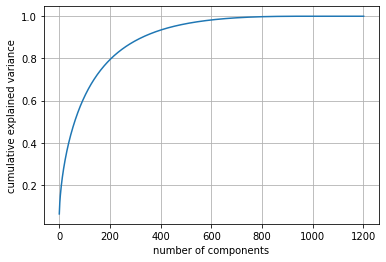

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train)
explained_variance=pca.explained_variance_ratio_

plt.plot(np.cumsum(explained_variance))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

我們從上圖可以看到大概在300個主成分時大約有近90%的變異可以被解釋

因此我們要選取其中前300個column當作我們的feature

In [ ]:
X_train_transform=pca.fit_transform(X_train)
X_test_transform=pca.transform(X_test)

X_train_transform=X_train_transform[:,0:300]
X_test_transform=X_test_transform[:,0:300]

In [ ]:
from sklearn import manifold
#t-SNE
X_tsne = manifold.TSNE(n_components=2, init='pca', random_state=22, verbose=1).fit_transform(X_train_transform)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1202 samples in 0.001s...
[t-SNE] Computed neighbors for 1202 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1202
[t-SNE] Computed conditional probabilities for sample 1202 / 1202
[t-SNE] Mean sigma: 1.116224


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.814400
[t-SNE] KL divergence after 1000 iterations: 1.179865


In [ ]:

import plotly.express as px
fig = px.scatter_3d(
    X_tsne, x=0, y=1, z=2,
    color=Y_pca, labels={'color': 'green'}
)
fig.update_traces(marker_size=8)
fig.show()

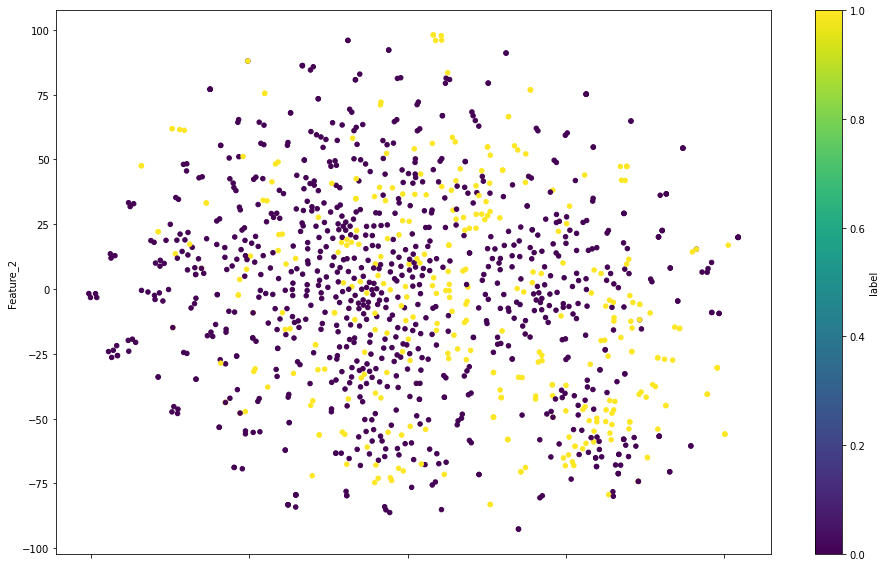

In [ ]:
import pandas

df123 = pandas.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=Y_train))

df123.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='viridis',figsize=(16,10))

## Logistic Regreesion

In [ ]:
# model
model = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

LR_RandSearch = RandomSearch(X_train_transform,Y_train,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_test_transform)

Best: 0.798636 using {'C': 0.3933873353322004, 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


460 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
460 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: S

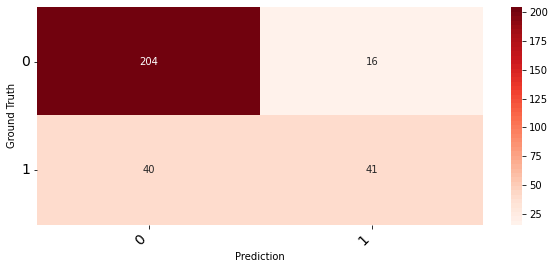

Accuray: 81.395%
ROC-AUC: 0.71672
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       220
           1       0.72      0.51      0.59        81

    accuracy                           0.81       301
   macro avg       0.78      0.72      0.74       301
weighted avg       0.80      0.81      0.80       301



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_LR)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_LR), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_LR), 5)}""")
print(classification_report(Y_test, Prediction_LR))

result = classification_report(Y_test, Prediction_LR)

## KNN

In [ ]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

KNN_GridSearch = GridSearch(X_train_transform,Y_train,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_test_transform)

Prediction_KNN_train = KNN_GridSearch.BestModelPridict(X_train_transform)

Best: 0.788657 using {'n_neighbors': 2}
Best: 0.788657 using {'n_neighbors': 2}


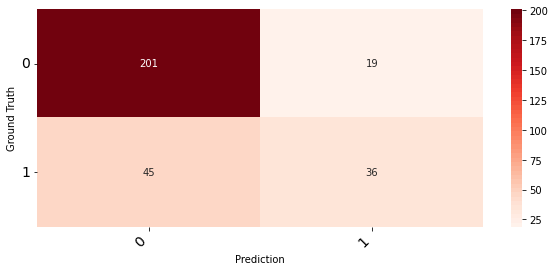

Accuray: 78.738%
ROC-AUC: 0.67904
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       220
           1       0.65      0.44      0.53        81

    accuracy                           0.79       301
   macro avg       0.74      0.68      0.70       301
weighted avg       0.77      0.79      0.77       301



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_KNN)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_KNN), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_KNN), 5)}""")

print(classification_report(Y_test, Prediction_KNN))

## SVM

In [ ]:
Y_train_svm = np.where(Y_train <= 0.5, -1, 1)
Y_test_svm = np.where(Y_test <= 0.5, -1, 1)
model_svm = svm.SVC()
kenel=['rbf', 'poly', 'sigmoid']
C=[0.1,1, 10, 100]
gamma=[1,0.1,0.01,0.001]
parameters=dict(kernel=kenel,C=C,gamma=gamma)
svm_GridSearch = GridSearch(X_train_transform,Y_train_svm,model_svm,parameters)
Prediction_svm = svm_GridSearch.BestModelPridict(X_test_transform)

Best: 0.813629 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best: 0.813629 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


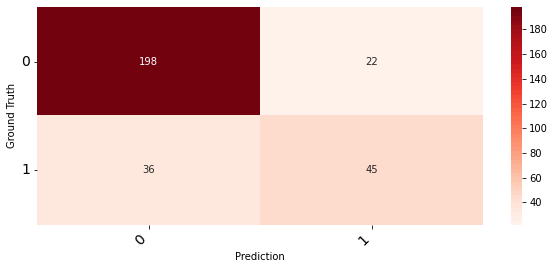

Accuray: 80.731%
ROC-AUC: 0.72778
              precision    recall  f1-score   support

          -1       0.85      0.90      0.87       220
           1       0.67      0.56      0.61        81

    accuracy                           0.81       301
   macro avg       0.76      0.73      0.74       301
weighted avg       0.80      0.81      0.80       301



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test_svm, Prediction_svm)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test_svm, Prediction_svm), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test_svm, Prediction_svm), 5)}""")
print(classification_report(Y_test_svm, Prediction_svm))


## XGBoost

In [ ]:
learning_rate_value = [.1,.3,.5,1]
n_estimators_value = [300,400,500]
model_GB = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(X_train_transform,Y_train,model_GB,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test_transform)

In [ ]:
model_GB = GradientBoostingClassifier(random_state=123, n_estimators=400, learning_rate=0.5)
model_GB = model_GB.fit(X_train_transform, Y_train)
# calculating score on training data
print("model_GB training data score: ", model_GB.score(X_train_transform, Y_train))
# calculating score on testing data
print("model_GB testing data score: ", model_GB.score(X_test_transform, Y_test))

#Predict the response for test dataset
pred_GB = model_GB.predict(X_test_transform)
# accuracy

accuracy = accuracy_score(Y_test, pred_GB)
print(accuracy)

In [ ]:
# Plot AUC, ROC
print(f'Accuray: {round(accuracy_score(Y_test, pred_GB), 5) * 100}%ROC-AUC: {round(roc_auc_score(Y_test, pred_GB), 5)}')
print(classification_report(Y_test, pred_GB))



## Random Forest

In [ ]:
import numpy as np 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [24,30,36]
# Minimum number of samples required to split a node
min_samples_split = [4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.metrics import accuracy_score
model_RF = RandomForestClassifier()
RF_GridSearch = GridSearch(X_train_transform,Y_train,model_RF,param_grid)
Prediction_RF = RF_GridSearch.BestModelPridict(X_test_transform)

accuracy = accuracy_score(Y_test, Prediction_RF)
print(accuracy)

In [ ]:
# AUC, ROC
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_RF), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_RF), 5)}""")
print(classification_report(Y_test, Prediction_RF))

## 統整 






In [ ]:
result_dict = {} 
result_dict["Logistic"] = round(accuracy_score(Y_test, Prediction_LR), 5)
result_dict["KNN"] = round(accuracy_score(Y_test, Prediction_KNN), 5)
#result_dict["Decision Tree"] = round(accuracy_score(Y_test, Prediction_Cart), 5)
result_dict["SVM"] = round(accuracy_score(Y_test_svm, Prediction_svm), 5)
result_dict["XGB"] = round(accuracy_score(Y_test, pred_GB), 5)
result_dict["RF"] = round(accuracy_score(Y_test, Prediction_RF), 5)

result_table = pd.DataFrame(result_dict.items())
result_table.rename(columns={0: 'Model',1: 'Testing Accuracy'}, inplace=True)

In [ ]:
result_table_pca = result_table
result_table_pca

,Model,Testing Accuracy
0,Logistic,0.78738
1,KNN,0.79402
2,SVM,0.81063
3,XGB,0.81063
4,RF,0.80399


# Modeling and Inference (Green TF-IDF with cluster)

In [ ]:
# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

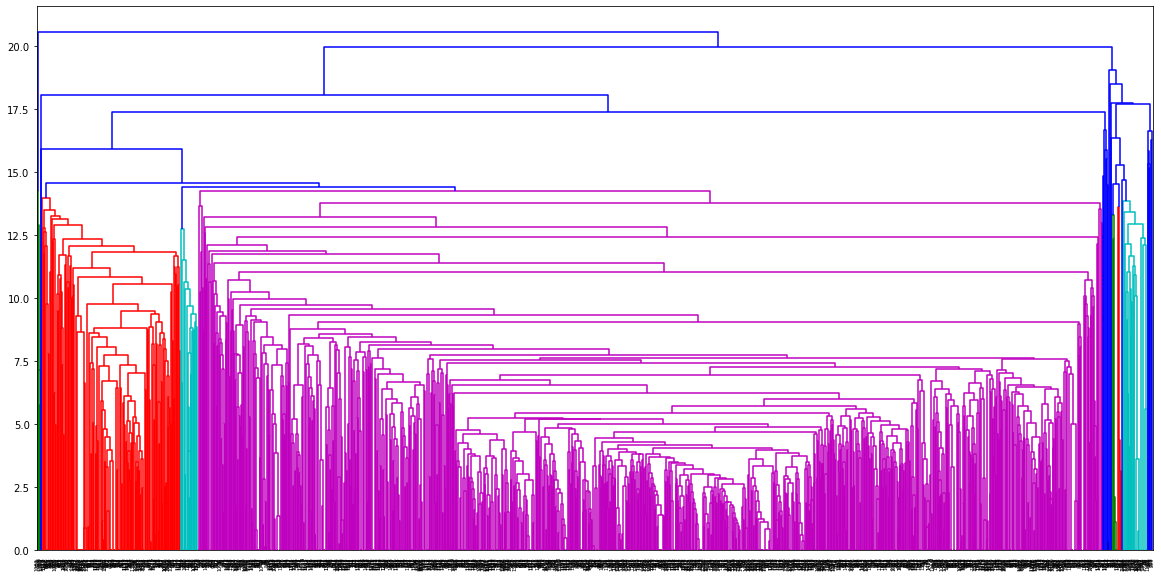

In [ ]:
# Complete Linkage
plt.figure(figsize = (20,10))
mergings = linkage(X_new, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

In [ ]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=2).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
df_hc = Y_df_pca.copy()
df_hc.head()
# assign cluster labels
df_hc['Cluster_labels'] = cluster_labels
df_hc

,label,Cluster_labels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1498,0,0
1499,0,0
1500,0,0
1501,0,0


In [ ]:
accuracy = accuracy_score(Y_pca, cluster_labels)
print(accuracy)

0.7152361942781105


# BERT Model

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 263 kB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
     |████████████████████████████████| 3.3 MB 37.0 MB/s 
     |████████████████████████████████| 895 kB 54.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import re
import torch
import string
import numpy as np
import pandas as pd
import transformers
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from google.colab import files
#uploaded = files.upload() # If you run this on colab you need to upload the spam.csv file to colab



#import nltk
#nltk.download("stopwords")
#nltk.download("punkt") # again if your running this in colab you'll probably need to first download the stopwords set and punkt from nltk



# Loading pretrained model/tokenizer
# This is the Distilled, base, uncased version of BERT 
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

# Tokenize the sentences adding the special "[CLS]" and "[SEP]" tokens
tokenized = df["statement_text"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,max_length=168,truncation=True))

# Get the length of the longest tokenized sentence
max_len = tokenized.apply(len).max() 

# Padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) 

# Create the attention mask so BERT knows to ignore the zeros used for padding
attention_mask = np.where(padded != 0, 1, 0)

# Create the input tensors
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

# Pass the inputs through DistilBERT
with torch.no_grad():
    encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

# Create a new dataframe with the encoded features
df_encoded = pd.DataFrame(encoder_hidden_state[0][:,0,:].numpy())

# Insert the original columns in the beginning of the encoded dataframe
#df_encoded.insert(loc=0, column='original_message', value=df["original_message"])
#df_encoded.insert(loc=0, column='spam', value=df["spam"])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_encoded.insert(loc=0, column='statement_text', value=df["statement_text"])
df_encoded.insert(loc=0, column='label', value=df["label"])

In [ ]:
df_encoded=df_encoded.dropna()
df_encoded

,label,statement_text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.0,"Electrical and electronic circuits, components...",-0.044008,0.146992,-0.058098,0.106097,-0.121193,0.057430,-0.103799,0.220731,-0.148744,-0.236965,-0.300803,-0.251168,0.053144,0.423936,-0.106226,0.256742,0.056267,0.059122,0.210610,0.127417,-0.196271,-0.086480,0.411521,-0.083390,0.250912,-0.379187,0.199357,-0.085515,0.071061,0.027404,-0.146140,0.484412,-0.259995,-0.188112,0.247210,-0.059187,0.201246,-0.364970,...,0.003837,-0.193947,0.079293,0.107938,-0.159543,-0.277141,0.227855,0.187743,-0.159738,0.113814,-0.382617,0.310605,0.188189,0.348314,0.045960,0.531198,0.224807,-0.024890,0.428416,0.175399,-0.196983,0.126972,-0.034161,0.364653,-4.883887,-0.493666,-0.263568,-0.109093,-0.250517,0.007058,0.393073,-0.436359,-0.002939,-0.330410,0.153757,-0.221332,0.065680,0.019633,0.031527,0.545657
1,0.0,"Electrical and electronic circuits, components...",-0.044008,0.146992,-0.058098,0.106097,-0.121193,0.057430,-0.103799,0.220731,-0.148744,-0.236965,-0.300803,-0.251168,0.053144,0.423936,-0.106226,0.256742,0.056267,0.059122,0.210610,0.127417,-0.196271,-0.086480,0.411521,-0.083390,0.250912,-0.379187,0.199357,-0.085515,0.071061,0.027404,-0.146140,0.484412,-0.259995,-0.188112,0.247210,-0.059187,0.201246,-0.364970,...,0.003837,-0.193947,0.079293,0.107938,-0.159543,-0.277141,0.227855,0.187743,-0.159738,0.113814,-0.382617,0.310605,0.188189,0.348314,0.045960,0.531198,0.224807,-0.024890,0.428416,0.175399,-0.196983,0.126972,-0.034161,0.364653,-4.883887,-0.493666,-0.263568,-0.109093,-0.250517,0.007058,0.393073,-0.436359,-0.002939,-0.330410,0.153757,-0.221332,0.065680,0.019633,0.031527,0.545657
2,0.0,Electrical and electronic circuits for active ...,-0.255357,-0.019322,-0.322842,0.058686,0.024176,0.107447,-0.153854,0.210621,-0.411118,-0.254049,-0.499510,-0.105550,0.011517,0.422867,0.014154,0.315058,0.050424,0.045551,0.164888,0.264420,-0.283312,-0.114052,0.333574,-0.032890,0.260606,-0.345471,0.083709,0.010874,0.047552,0.210318,-0.124472,0.406247,-0.228543,-0.379352,0.309326,-0.143262,0.063667,-0.594253,...,0.257973,-0.257774,0.251016,0.025217,-0.297428,-0.205967,0.163499,0.189898,-0.123331,0.218015,-0.340453,0.426799,-0.022009,0.341827,0.049312,0.279107,0.139748,0.096584,0.408641,0.202759,-0.306516,0.229867,-0.078730,0.501372,-4.969988,-0.658113,-0.494285,-0.225804,-0.029350,-0.159414,0.235821,-0.423647,0.048913,-0.144290,0.092909,-0.162453,0.135188,0.123267,0.215826,0.446365
3,0.0,"Electrical and electronic circuits, electrical...",0.003611,0.201536,-0.069905,0.140788,-0.111862,0.105081,-0.102381,0.209818,-0.265789,-0.318726,-0.460762,-0.186730,0.016137,0.507198,0.005717,0.390910,0.026329,0.081676,0.160494,0.319413,-0.251460,-0.071678,0.421153,-0.034963,0.328045,-0.414892,0.095475,0.046734,0.124040,0.071589,-0.111222,0.334762,-0.298472,-0.235922,0.410231,-0.068370,0.182875,-0.509300,...,0.236091,-0.229215,0.314263,0.114072,-0.256048,-0.257932,0.225221,0.261871,-0.221620,0.089457,-0.492523,0.468480,-0.002823,0.316063,0.120960,0.403502,0.232882,-0.096017,0.424258,0.235925,-0.201711,0.186051,-0.015040,0.338046,-5.043158,-0.488111,-0.386761,-0.089072,-0.147563,-0.042763,0.256481,-0.523698,-0.062670,-0.210547,0.144935,-0.172485,0.112195,0.024384,0.011419,0.480006
4,0.0,"Housewares, namely, bowls, cups, dishes, heat-...",-0.304842,0.114205,-0.073182,0.135448,0.151310,0.348359,-0.024342,0.499882,-0.504672,-0.000465,-0.422983,-0.192519,0.149561,0.453113,-0.197883,0.343409,0.010964,0.246790,0.256904,0.392890,-0.328531,-0.268848,0.090445,-0.189344,0.272773,-0.360316,-0.079648,0.100687,-0.117228,0.143896,-0.039663,0.416210,-0.109079,-0.301455,0.091532,-0.313742,0.443200,-0.306665,...,0.383511,-0.177426,0.160047,0.222594,-0.403442,-0.157139,0.198627,0.241080,-0.177238,0.10943

In [ ]:
# Initialize StandardScaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

# Dont standerdize binary columns and the text column
feats_to_scale = df_encoded.drop(["label", "statement_text"], axis=1)

# Create a new dataframe with the standardized features
scaled_features = pd.DataFrame(scaler.fit_transform(feats_to_scale))

# Update the dataset with the new standerdized features
scaled_df = df_encoded.copy()
scaled_df.update(scaled_features)

In [ ]:
X = scaled_df.drop(["label", "statement_text"], axis=1)
y = scaled_df["label"]

from sklearn.manifold import TSNE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=22)
X_embedded = TSNE(n_components=2, random_state=22).fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



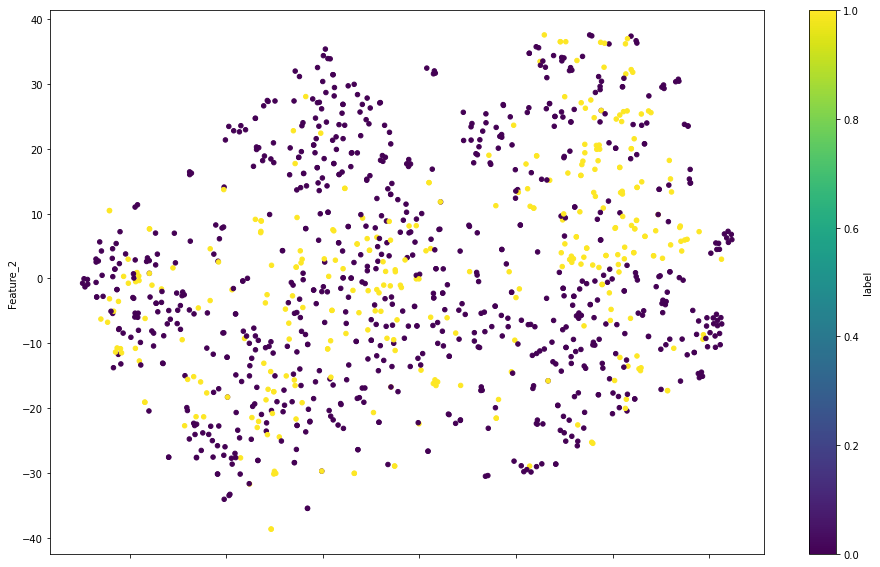

In [ ]:
import pandas

df_bert = pandas.DataFrame(dict(Feature_1=X_embedded[:,0], Feature_2=X_embedded[:,1], label=y_train))

df_bert.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='viridis',figsize=(16,10))

In [ ]:
# creating the dataframe for plotting
def creat_plotting_data(data, labels=y_train, rename=False):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["label"] = labels.to_numpy()
    
    if rename:
        df.rename({0:"non_Green", 1:"Green"}, axis=1, inplace=True)
        
    return df

# creating the dataframes for plotting
plotting_data_embedded = creat_plotting_data(X_embedded, rename=True)

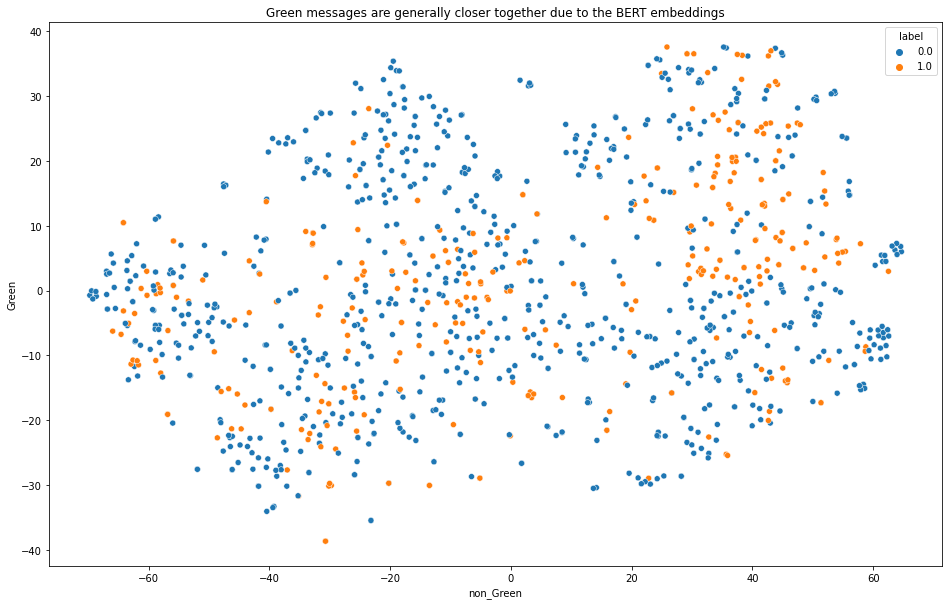

In [ ]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="non_Green", y="Green", hue="label", data=plotting_data_embedded)
ax.set(title = "Green messages are generally closer together due to the BERT embeddings")
plt.show()

In [ ]:

from keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization
model = Sequential()

model.add(Dense(1000, input_shape=(768,), activation="relu"))
model.add(BatchNormalization(axis=-1))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(10, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

In [ ]:
# defining the learning rate, the number of epochs and the batch size
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
INIT_LR = 0.001
NUM_EPOCHS = 30
BS = 256
opt = RMSprop(lr = INIT_LR)

# This is just a necessary step to compile the model, we don't actually need it because we're not using the old model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# Reduce the learning rate by half if validation accuracy has not increased in the last 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

fitted_network = model.fit(X_train, y_train, validation_split=0.2, batch_size=BS, epochs=NUM_EPOCHS, callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/30
4/4 [==============================] - 7s 358ms/step - loss: 0.8693 - accuracy: 0.5511 - val_loss: 0.5834 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 0s 104ms/step - loss: 0.7345 - accuracy: 0.6311 - val_loss: 0.6091 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - 0s 117ms/step - loss: 0.6357 - accuracy: 0.6733 - val_loss: 0.5722 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - 0s 135ms/step - loss: 0.5771 - accuracy: 0.7267 - val_loss: 0.5856 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 5/30
4/4 [==============================] - 0s 129ms/step - loss: 0.5484 - accuracy: 0.7300 - val_loss: 0.5858 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 6/30
4/4 [==============================] - 0s 115ms/step - loss: 0.5228 - accuracy: 0.7300 - val_loss: 0.4826 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 7/30
4/4 [==============================] - 1s 128ms/step - loss: 0.4766 - a

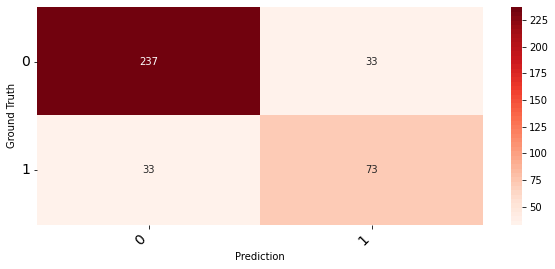

Accuray: 82.447%
ROC-AUC: 0.78323
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       270
         1.0       0.69      0.69      0.69       106

    accuracy                           0.82       376
   macro avg       0.78      0.78      0.78       376
weighted avg       0.82      0.82      0.82       376



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
# predict results
preds = np.round(model.predict(X_test)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")
print(classification_report(y_test, preds))

In [ ]:
learning_rate_value = [.1,.3,.5,1]
n_estimators_value = [300,400,500]
model_GB = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(X_train,y_train,model_GB,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test)

In [ ]:
model_GB = GradientBoostingClassifier(random_state=123, n_estimators=400, learning_rate=0.5)
model_GB = model_GB.fit(X_train, y_train)
# calculating score on training data
print("model_GB training data score: ", model_GB.score(X_train, y_train))
# calculating score on testing data
print("model_GB testing data score: ", model_GB.score(X_test, y_test))

#Predict the response for test dataset
pred_GB = model_GB.predict(X_test)
# accuracy

accuracy = accuracy_score(y_test, pred_GB)
print(accuracy)

model_GB training data score:  0.9849023090586145
model_GB testing data score:  0.8111702127659575
0.8111702127659575


In [ ]:
# Plot AUC, ROC
print(f'Accuray: {round(accuracy_score(y_test, pred_GB), 5) * 100}%ROC-AUC: {round(roc_auc_score(y_test, pred_GB), 5)}')
print(classification_report(y_test, pred_GB))

Accuray: 81.11699999999999%ROC-AUC: 0.75678
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       270
         1.0       0.68      0.63      0.65       106

    accuracy                           0.81       376
   macro avg       0.77      0.76      0.76       376
weighted avg       0.81      0.81      0.81       376



# Word2Vector Method

1.   清單項目
2.   清單項目



## pre-process text data

In [ ]:
df = pd.read_excel('/content/drive/My Drive/統計學習期末/green_trademark_label.xlsx')
df=df[["Green_TM_Label","statement_text"]]
df=df.dropna()
df=df.rename(columns={'Green_TM_Label': 'label'}) 
df["category"]=df['label']
map_dict = {1: "Green", 0:"non_Green"}
df['category'].replace(map_dict, inplace=True)

!pip install text-hammer
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
  
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

cleaned_df = text_preprocessing(df, "statement_text")


from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(cleaned_df.statement_text, cleaned_df.label, test_size = 0.2, stratify = cleaned_df.label
                                                 ,random_state = 22)
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 15000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=500,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 500, padding = 'post')

     |████████████████████████████████| 115 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

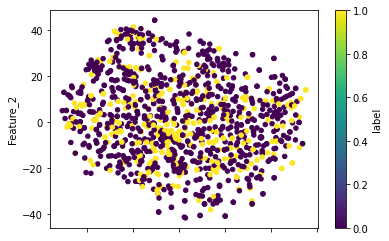

In [ ]:
import pandas

from sklearn.manifold import TSNE
X_embedded_2 = TSNE(n_components=2, random_state=22).fit_transform(X_train_pad)

df_w2v = pandas.DataFrame(dict(Feature_1=X_embedded_2[:,0], Feature_2=X_embedded_2[:,1], label=y_train))

df_w2v.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='viridis')

In [ ]:
X_embedded_3 = TSNE(n_components=3, random_state=22).fit_transform(X_train_pad)
import plotly.express as px
fig = px.scatter_3d(
    X_embedded_3, x=0, y=1, z=2,
    color=y_train, labels={'color': 'green'}
)
fig.update_traces(marker_size=8)
fig.show()

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') # this would download vector with 100 dimension

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
glove_gensim['cat'].shape[0] # this is the diemnsion of the vectors

100

In [ ]:

# now lets connvert all the words we have in our data into vectors 
vector_size = 100
gensim_weight_matrix = np.zeros((10000 ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < 10000: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

# designing our architecture 
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = 10000,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model_gensim.add(Dense(1, activation = 'sigmoid'))
model_gensim.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')


from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 35, batch_size = 120, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )

model_gensim.evaluate(X_test_pad, y_test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Epoch 1/35
11/11 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.7072
Epoch 00001: val_accuracy improved from -inf to 0.75415, saving model to ./model_gensim.h5
11/11 [==============================] - 28s 2s/step - loss: 0.5881 - accuracy: 0.7072 - val_loss: 0.5278 - val_accuracy: 0.7542
Epoch 2/35
11/11 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.7413
Epoch 00002: val_accuracy did not improve from 0.75415
11/11 [==============================] - 14s 1s/step - loss: 0.5352 - accuracy: 0.7413 - val_loss: 0.5981 - val_accuracy: 0.7342
Epoch 3/35
11/11 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.7396
Epoch 00003: val_accuracy did not improve from 0.75415
11/11 [==============================] - 14s 1s/step - loss: 0.5663 - accuracy: 0.7396 - val_loss: 0.5407 - val_accuracy: 0.7309
Epoch 4/35
11/11 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.7571
Epoch 00004: val_accuracy improved f

[0.4634138345718384, 0.7940199375152588]

In [ ]:
from sklearn import metrics
y_pred_gensim = np.where(model_gensim.predict(X_test_pad)>0.5,1,0)
print(metrics.classification_report(y_pred_gensim, y_test))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       217
           1       0.71      0.71      0.71        84

    accuracy                           0.84       301
   macro avg       0.80      0.80      0.80       301
weighted avg       0.84      0.84      0.84       301



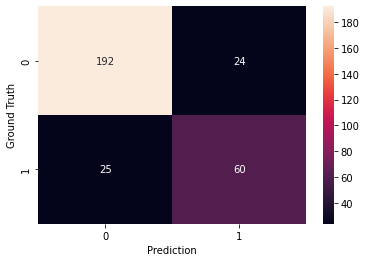

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_gensim)
cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Performance

In [ ]:
result_table_pca

,Model,Testing Accuracy
0,Logistic,0.78738
1,KNN,0.79402
2,SVM,0.81063
3,XGB,0.81063
4,RF,0.80399
